# 0. Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from src.data_module.preprocessing import (
    load_and_concat_folder,
    normalize_wind_dir,
    handle_physical_violations,
    COLUMN_MAP,
    POSITIVE_COLUMNS,
    PERCENTILE_CLAMP_VALUES,
)

# 1. Inspect raw data


In [4]:
raw_path = "data/raw/Group 3"  # adapt if needed

df_raw = load_and_concat_folder(raw_path)
df_raw = df_raw.rename(columns=COLUMN_MAP)

print(df_raw.columns)
print(df_raw.shape)

[INFO] Loading UH_2019_07.csv
[INFO] Loading UH_2019_08.csv
[INFO] Loading UH_2019_09.csv
[INFO] Loading UH_2019_10.csv
[INFO] Loading UH_2019_11.csv
[INFO] Loading UH_2019_12.csv
[INFO] Loading UH_2020_01.csv
[INFO] Loading UH_2020_02.csv
[INFO] Loading UH_2020_03.csv
[INFO] Loading UH_2020_04.csv
[INFO] Loading UH_2020_05.csv
[INFO] Loading UH_2020_06.csv
[INFO] Concatenated 12 CSVs → 8673 rows
Index(['date', 'rh[-]', 'rad[W/m^2]', 'wind_speed[m/s]', 'air_temp[C]',
       'wind_dir[deg]', 'cooling_power[kW]', 'energy_carrier_cooling[m^3/h]',
       'heat_power[kW]', 'energy_carrier_heating[m^3/h]'],
      dtype='object')
(8673, 10)


In [5]:
df_raw.head()

,date,rh[-],rad[W/m^2],wind_speed[m/s],air_temp[C],wind_dir[deg],cooling_power[kW],energy_carrier_cooling[m^3/h],heat_power[kW],energy_carrier_heating[m^3/h]
0,2019-07-01 01:00:00,58.733333,0.000000,2.966667,20.718333,296.433333,0.770000,0.560,1.376667,0.094667
1,2019-07-01 02:00:00,61.833333,0.003333,3.170000,19.241667,316.266667,0.941667,0.484,1.326667,0.086333
2,2019-07-01 03:00:00,66.733333,0.483333,3.008333,18.100000,303.266667,0.910000,0.445,1.393333,0.109167
3,2019-07-01 04:00:00,70.433333,8.061667,2.556667,17.285000,308.650000,0.825000,0.385,1.335000,0.119500
4,2019-07-01 05:00:00,72.600000,37.366667,2.910000,16.858333,314.500000,1.756667,1.255,1.378333,0.089833


In [6]:
df_raw.isna().sum()

date                             0
rh[-]                            0
rad[W/m^2]                       0
wind_speed[m/s]                  0
air_temp[C]                      0
wind_dir[deg]                    0
cooling_power[kW]                0
energy_carrier_cooling[m^3/h]    0
heat_power[kW]                   0
energy_carrier_heating[m^3/h]    0
dtype: int64

In [7]:
df_raw.describe().round(2)

,rh[-],rad[W/m^2],wind_speed[m/s],air_temp[C],wind_dir[deg],cooling_power[kW],energy_carrier_cooling[m^3/h],heat_power[kW],energy_carrier_heating[m^3/h]
count,8673.00,8673.00,8673.00,8673.00,8673.00,8673.00,8673.00,8673.00,8673.00
mean,76.71,40.62,4.87,8.97,187.58,1.40,0.39,8.14,0.15
std,18.85,65.65,90.19,6.88,125.36,6.67,4.01,7.80,3.10
min,25.55,0.00,0.11,-5.29,15.12,-165.78,-166.20,-165.31,-166.46
25%,63.62,0.00,1.25,3.84,87.72,0.65,0.38,1.74,0.12
50%,80.45,2.06,1.89,7.18,202.48,0.82,0.43,6.86,0.19
75%,93.12,57.44,2.55,14.07,269.57,0.95,0.53,11.68,0.26
max,100.00,276.32,3276.70,30.48,3277.00,123.35,7.34,51.56,0.87


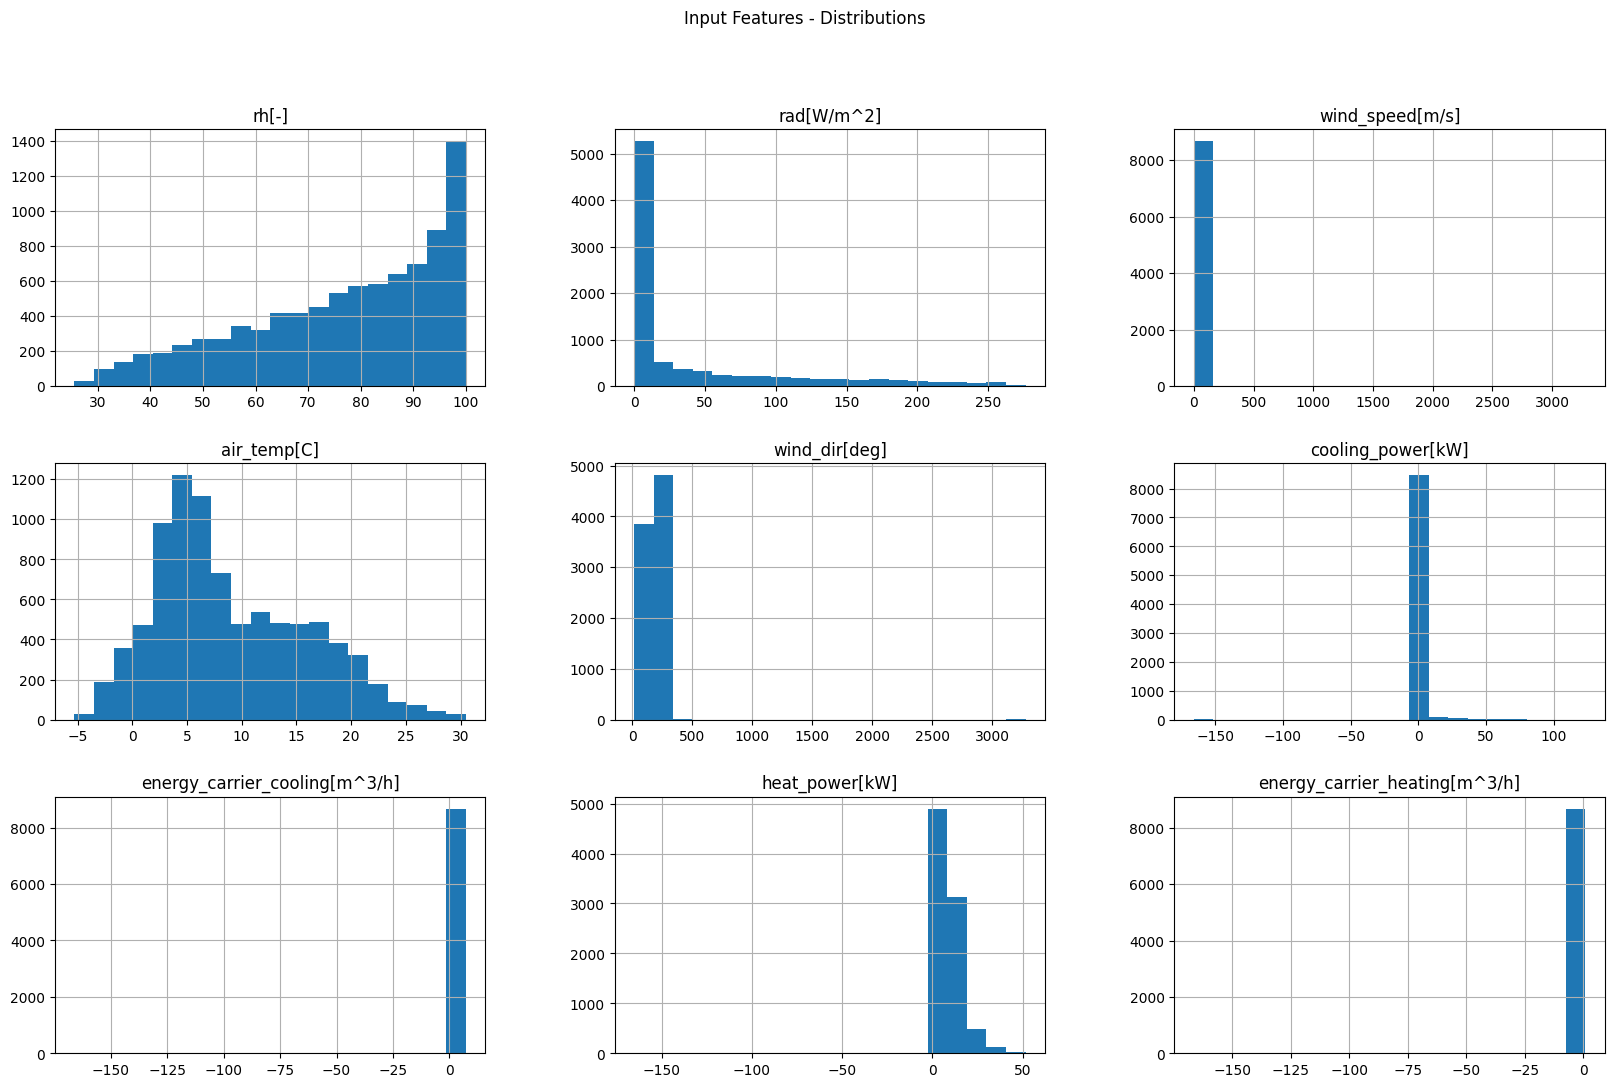

In [8]:
df_raw.hist(
    figsize=(20, 12), bins=20
)
plt.suptitle("Input Features - Distributions")

plt.show()

In [9]:
df_prep = df_raw.copy()

# handle nans 
n_rows_has_na = df_prep.isna().any(axis=1).sum()
if n_rows_has_na > 0:
    print(f"Dropping {n_rows_has_na} rows with NaN values...")
    df_prep = df_prep.dropna().reset_index(drop=True)
    print(f"Data shape after dropping NaNs: {df_prep.shape}")
else:
    print(f"No NaN values found, shape remains: {df_prep.shape}")

# drop rows with physical violations
print("\nHandling physical violations...")
for col in POSITIVE_COLUMNS:
    n_violations = (df_prep[col] < 0).sum()
    print(f"Number of negative values in column '{col}': {n_violations}")
    df_prep = handle_physical_violations(df_prep, col, min_val=0.0, strategy="drop")
print(f"Data shape after handling physical violations: {df_prep.shape}")

# normaliwe wind direction
print("\nNormalizing wind direction...")
df_prep = normalize_wind_dir(df_prep, col="wind_dir[deg]")
print(f"Wind direction normalization complete. min: {df_prep['wind_dir[deg]'].min():.1f} deg, max: {df_prep['wind_dir[deg]'].max():.1f} deg")

# clamping outliers
print("\nClamping outliers based on percentiles...")
for col, (q_low, q_high) in PERCENTILE_CLAMP_VALUES.items():
    print(f"    Clamping column '{col}' to percentiles {q_low} ~ {q_high}...")
    lower_bound = df_prep[col].quantile(q_low / 100)
    upper_bound = df_prep[col].quantile(q_high / 100)
    df_prep[col] = df_prep[col].clip(lower=lower_bound, upper=upper_bound)

No NaN values found, shape remains: (8673, 10)

Handling physical violations...
Number of negative values in column 'energy_carrier_cooling[m^3/h]': 5
Number of negative values in column 'energy_carrier_heating[m^3/h]': 1
Number of negative values in column 'cooling_power[kW]': 2
Number of negative values in column 'heat_power[kW]': 0
Data shape after handling physical violations: (8665, 10)

Normalizing wind direction...
Wind direction normalization complete. min: 14.6 deg, max: 349.6 deg

Clamping outliers based on percentiles...
    Clamping column 'rad[W/m^2]' to percentiles 0 ~ 95...
    Clamping column 'wind_speed[m/s]' to percentiles 0 ~ 99...
    Clamping column 'cooling_power[kW]' to percentiles 0 ~ 99...
    Clamping column 'heat_power[kW]' to percentiles 0 ~ 99...
    Clamping column 'energy_carrier_cooling[m^3/h]' to percentiles 0 ~ 99...
    Clamping column 'energy_carrier_heating[m^3/h]' to percentiles 0 ~ 99...


In [10]:
df_prep.describe().round(2)

,rh[-],rad[W/m^2],wind_speed[m/s],air_temp[C],wind_dir[deg],cooling_power[kW],energy_carrier_cooling[m^3/h],heat_power[kW],energy_carrier_heating[m^3/h]
count,8665.00,8665.00,8665.00,8665.00,8665.00,8665.00,8665.00,8665.00,8665.00
mean,76.71,39.01,1.97,8.97,184.81,1.30,0.47,8.15,0.21
std,18.85,61.03,0.96,6.88,92.34,3.34,0.24,6.97,0.11
min,25.55,0.00,0.11,-5.29,14.57,0.00,0.00,0.00,0.00
25%,63.62,0.00,1.25,3.84,87.22,0.65,0.38,1.74,0.12
50%,80.45,2.07,1.89,7.18,201.65,0.82,0.43,6.86,0.19
75%,93.12,57.51,2.55,14.07,269.42,0.95,0.53,11.69,0.26
max,100.00,196.92,4.85,30.48,349.63,27.27,1.98,33.85,0.61


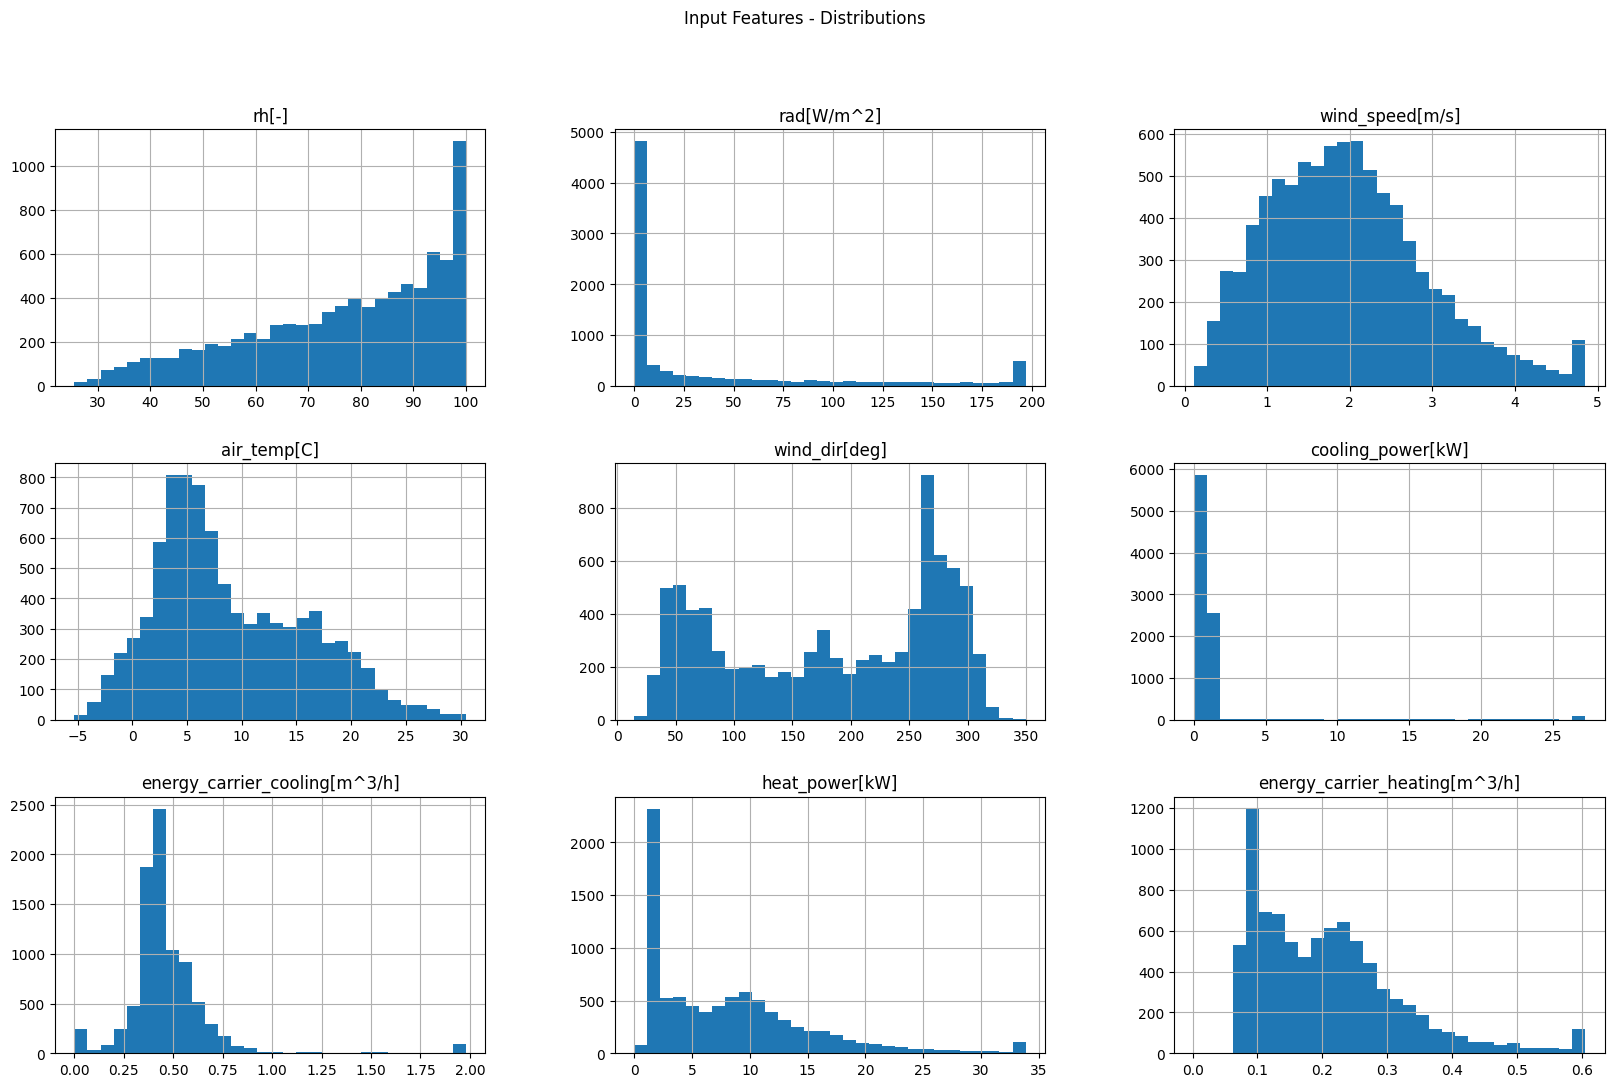

In [11]:
df_prep.hist(
    figsize=(20, 12), bins=30
)
plt.suptitle("Input Features - Distributions")

plt.show()

rh[-]                               Axes(0.125,0.712609;0.168478x0.167391)
rad[W/m^2]                       Axes(0.327174,0.712609;0.168478x0.167391)
wind_speed[m/s]                  Axes(0.529348,0.712609;0.168478x0.167391)
air_temp[C]                      Axes(0.731522,0.712609;0.168478x0.167391)
wind_dir[deg]                       Axes(0.125,0.511739;0.168478x0.167391)
cooling_power[kW]                Axes(0.327174,0.511739;0.168478x0.167391)
energy_carrier_cooling[m^3/h]    Axes(0.529348,0.511739;0.168478x0.167391)
heat_power[kW]                   Axes(0.731522,0.511739;0.168478x0.167391)
energy_carrier_heating[m^3/h]        Axes(0.125,0.31087;0.168478x0.167391)
dtype: object

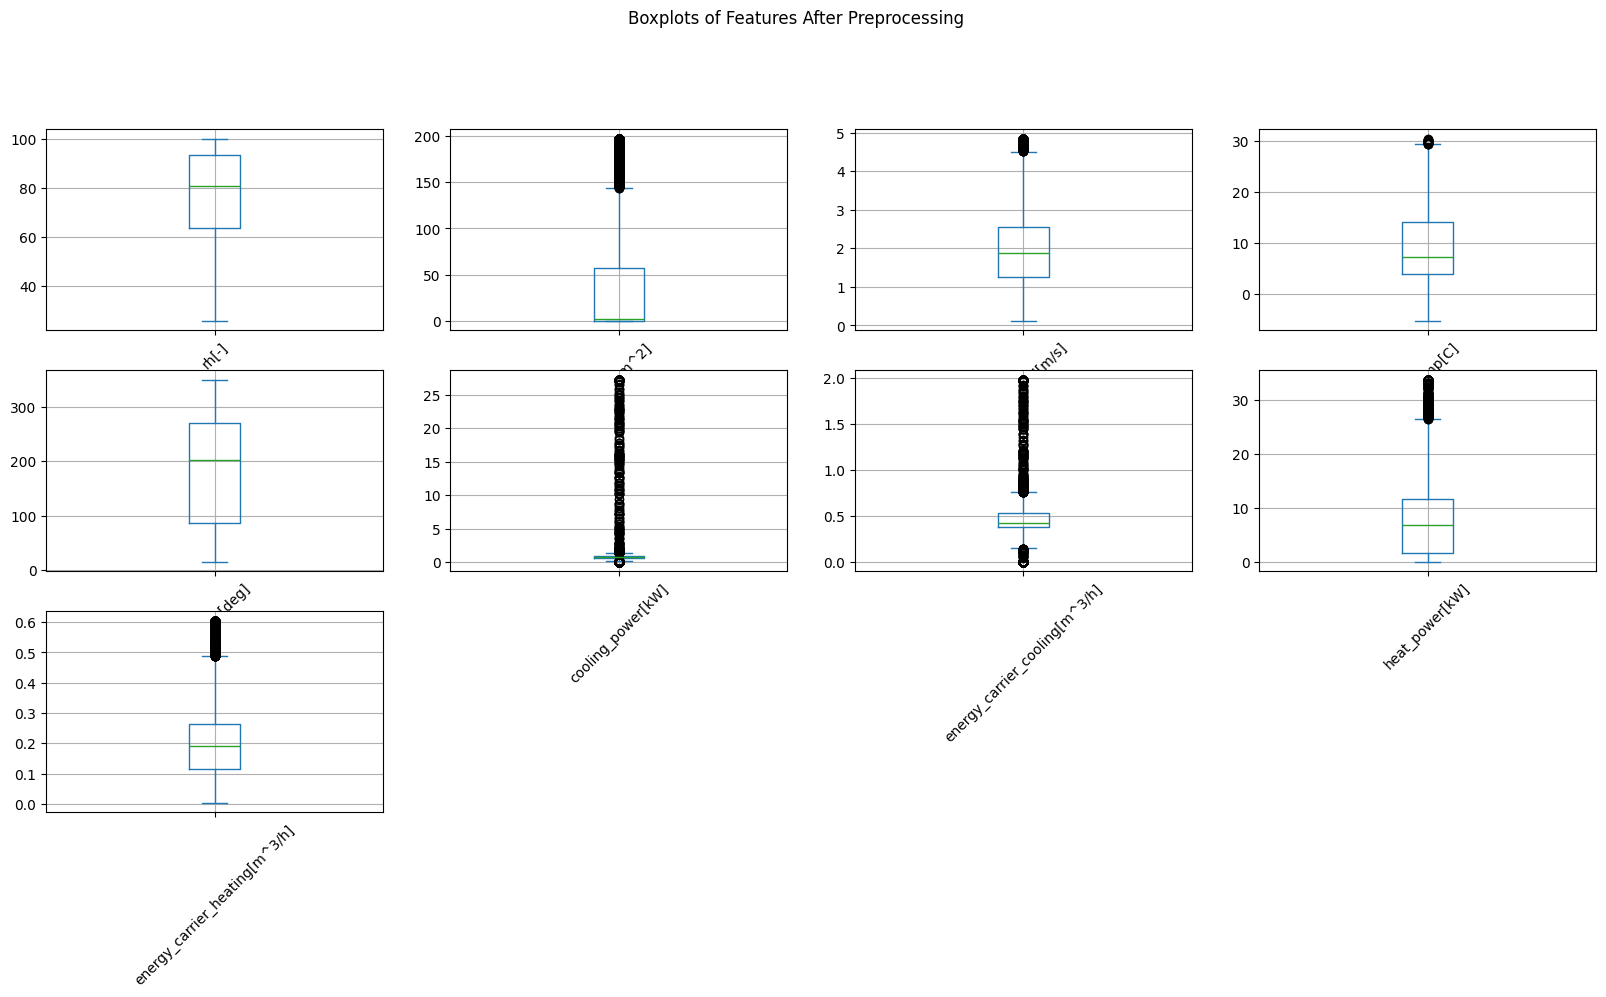

In [ ]:
df_prep.plot(kind='box',
             figsize=(20, 12),
             rot=45, subplots=True, layout=(4,4), grid=True, title="Boxplots of Features After Preprocessing")

In [ ]:
# # Pick x and y
# save_dir = Path("data/preprocessed_backup")

# BASE_FEATURES = [
#     "rh[-]",
#     "rad[W/m^2]",
#     "wind_speed[m/s]",
#     "wind_dir[deg]",
#     "air_temp[C]",
# ]
# HOT_SPECIFIC_FEATURES = [
#     "energy_carrier_heating[m^3/h]",
# ]
# COLD_SPECIFIC_FEATURES = [
#     "energy_carrier_cooling[m^3/h]",
# ]

# TARGET_COLUMN_HOT = "heat_power[kW]"
# TARGET_COLUMN_COLD = "cooling_power[kW]"

# hot_npz_path = save_dir / "cleaned_x_y_hot.npz"
# cold_npz_path = save_dir / "cleaned_x_y_cold.npz"

# def pick_x_y(df: pd.DataFrame, target_column: str, specific_features: list[str]) -> tuple[pd.DataFrame, pd.Series]:
#     feature_columns = BASE_FEATURES + specific_features
#     X = df[feature_columns]
#     y = df[target_column]
#     return X, y

# X_hot, y_hot = pick_x_y(df_prep, TARGET_COLUMN_HOT, HOT_SPECIFIC_FEATURES)
# X_cold, y_cold = pick_x_y(df_prep, TARGET_COLUMN_COLD, COLD_SPECIFIC_FEATURES)

# np.savez_compressed(hot_npz_path, X=X_hot.to_numpy(), y=y_hot.to_numpy(), feat_names=X_hot.columns.to_list())
# np.savez_compressed(cold_npz_path, X=X_cold.to_numpy(), y=y_cold.to_numpy(), feat_names=X_cold.columns.to_list())
# print(f"Saved hot dataset to: {hot_npz_path}")
# print(f"Saved cold dataset to: {cold_npz_path}")

Saved hot dataset to: data/preprocessed/cleaned_x_y_hot.npz
Saved cold dataset to: data/preprocessed/cleaned_x_y_cold.npz


## c) Correlation between inputs and target

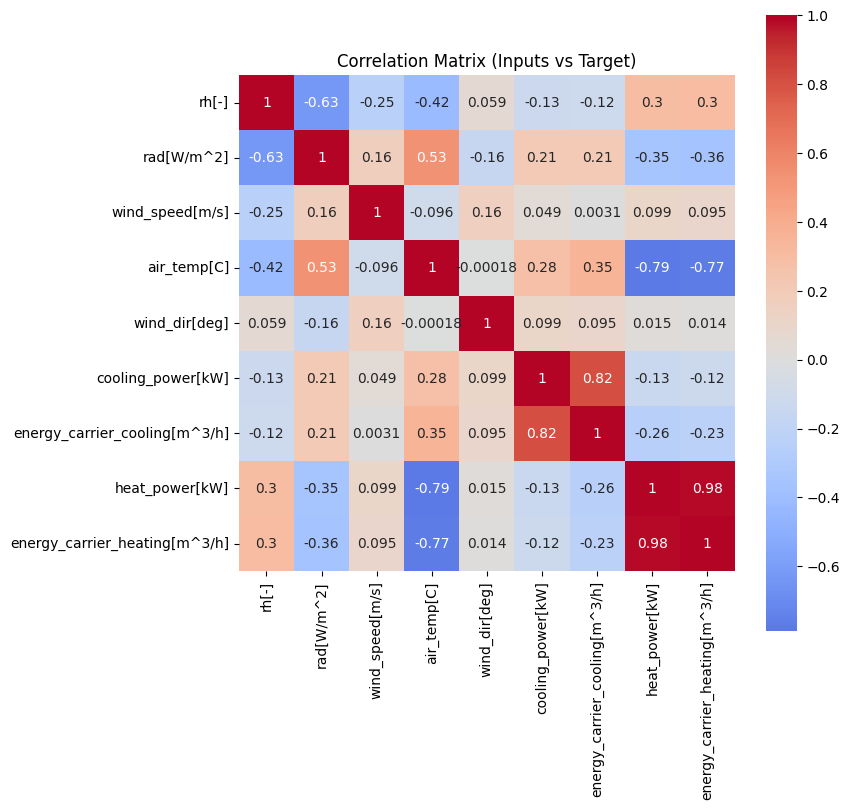

In [15]:
corr_df = df_prep.drop(columns=["date"]).corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", center=0, square=True)
plt.title("Correlation Matrix (Inputs vs Target)")
plt.show()